# 딥러닝응용 참고코드
텐서플로우를 사용해서 코드 작성
abalone dataset에 대해 CNN, LSTM으로 회귀를 수행하라

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('abalone.csv')
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Check Null
df.isna().sum()

,0
id,0
Sex,0
Length,0
Diameter,0
Height,0
Whole_weight,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


In [5]:
# Drop ID
df = df.drop(['id'], axis=1)
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [7]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Text(0.5, 1.0, 'Abalone')

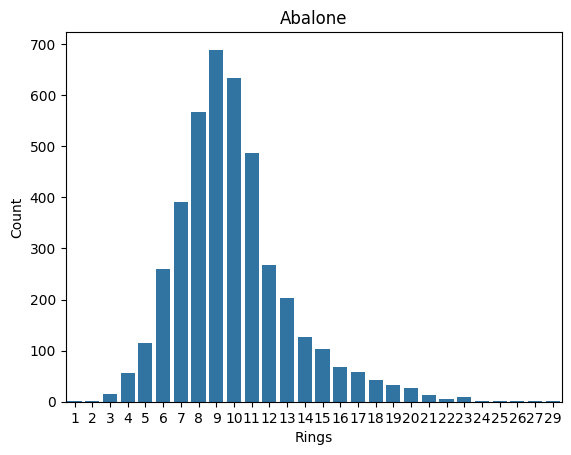

In [8]:
# Target Distribution

sns.countplot(data = df, x="Rings")
plt.xlabel("Rings")
plt.ylabel("Count")
plt.title("Abalone")

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

In [26]:
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :-1]
        seq_y = np.mean(sequences[i:end_ix, -1])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [31]:
n_steps = 5

X = df.drop(['Rings'], axis=1)
y = df['Rings'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [33]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]
X_train, y_train = split_sequences(train_set, 5)
X_test, y_test = split_sequences(test_set, 5)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3337, 5, 8), y_train shape: (3337,)
X_test shape: (832, 5, 8), y_test shape: (832,)


## CNN Regression

In [20]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

In [21]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

In [22]:
# CNN Model
inputs = Input(shape=input_shape)

# Convolutional Layer 1
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)

# Convolutional Layer 2
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# Flatten the output
flatten = Flatten()(pool2)

# Dense Layers
dense1 = Dense(128, activation='relu')(flatten)
outputs = Dense(1)(dense1)

# Model
cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cnn_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 44.3779 - mse: 44.3779 - val_loss: 4.3378 - val_mse: 4.3378
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7525 - mse: 4.7525 - val_loss: 1.7090 - val_mse: 1.7090
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3698 - mse: 2.3698 - val_loss: 1.5197 - val_mse: 1.5197
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7539 - mse: 1.7539 - val_loss: 1.5628 - val_mse: 1.5628
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6064 - mse: 1.6064 - val_loss: 1.2546 - val_mse: 1.2546
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4752 - mse: 1.4752 - val_loss: 1.2145 - val_mse: 1.2145
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3046 - mse: 1.3046 - val_loss: 1.3791 - val_mse: 1.3791
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1628 - mse: 1.1628 - val_loss: 1.1349 - val_mse: 1.1349
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2465 - mse

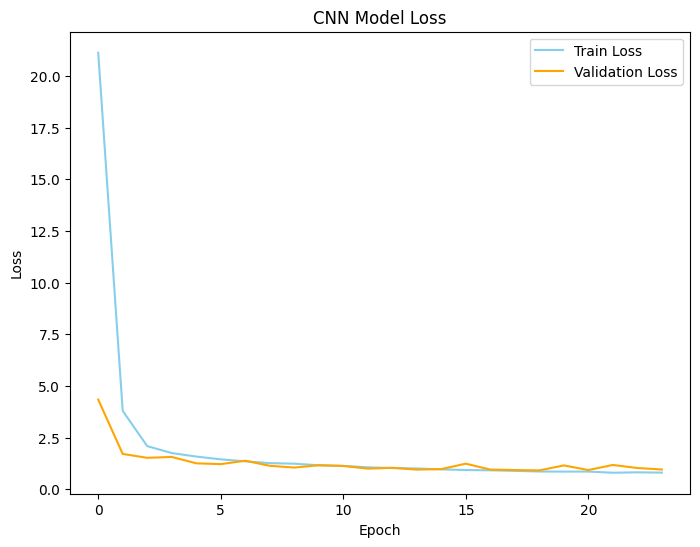

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Loss Plot
plt.plot(cnn_history.history['loss'], label='Train Loss', color='skyblue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [36]:
cnn_model.evaluate(X_train, y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7561 - mse: 0.7561


[0.792730987071991, 0.792730987071991]

In [37]:
cnn_model.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3566 - mse: 1.3566 


[1.1881062984466553, 1.1881062984466553]

### LSTM Regression


In [38]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow import keras

In [40]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

#### Complex LSTM

In [43]:
# LSTM Model
inputs = Input(shape=input_shape)

# LSTM Layer
lstm = LSTM(128, return_sequences=True)(inputs)
lstm2 = LSTM(64, return_sequences=False)(lstm)

# Dense Layer
dense1 = Dense(64, activation='relu')(lstm2)
dense2 = Dense(32, activation='relu')(dense1)
outputs = Dense(1)(dense2)

lstm_model = keras.Model(inputs=inputs, outputs=outputs)
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
lstm_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 5, 128)              │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,825 (491.50 KB)

 Trainable params: 125,825 (491.50 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 58.0100 - mse: 58.0100 - val_loss: 1.8538 - val_mse: 1.8538
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.9835 - mse: 1.9835 - val_loss: 1.4750 - val_mse: 1.4750
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.5993 - mse: 1.5993 - val_loss: 1.3004 - val_mse: 1.3004
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.5152 - mse: 1.5152 - val_loss: 1.2238 - val_mse: 1.2238
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.3011 - mse: 1.3011 - val_loss: 1.1837 - val_mse: 1.1837
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2217 - mse: 1.2217 - val_loss: 1.0944 - val_mse: 1.0944
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2412 - mse: 1.2412 - val_loss: 1.2168 - val_mse: 1.2168
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.3474 - mse: 1.3474 - val_loss: 1.1269 - val_mse: 1.1269
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.

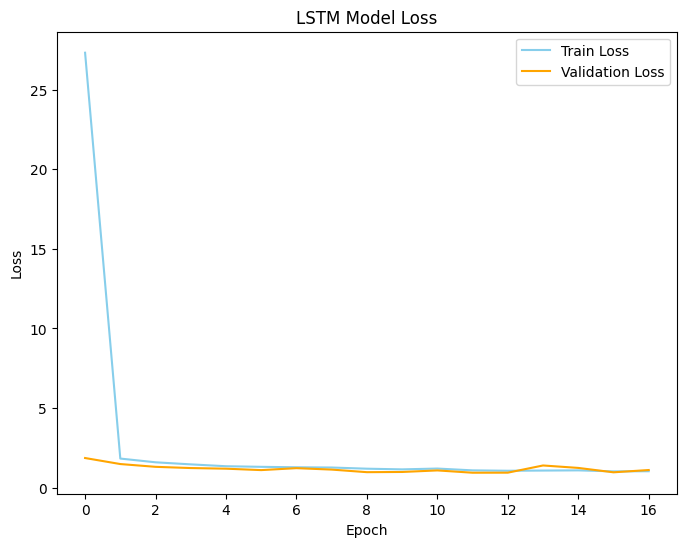

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Loss Plot
plt.plot(lstm_history.history['loss'], label='Train Loss', color='skyblue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [46]:
lstm_model.evaluate(X_train, y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9457 - mse: 0.9457


[0.9985566139221191, 0.9985566139221191]

In [47]:
lstm_model.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2872 - mse: 1.2872


[1.1373677253723145, 1.1373677253723145]

### DNN Regression

In [60]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

# DNN Model
inputs = Input(shape=input_shape)

# Dense Layers
dense1 = Dense(128, activation='relu')(inputs)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)

# Output Layer
outputs = Dense(1)(dense3)

# Compile Model
dnn_model = keras.Model(inputs=inputs, outputs=outputs)
dnn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
dnn_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5, 128)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 5, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5, 32)               │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Early Stopping Callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Fit Model
dnn_history = dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 61.1742 - mse: 61.1742 - val_loss: 6.5763 - val_mse: 6.5763
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3660 - mse: 5.3660 - val_loss: 2.8300 - val_mse: 2.8300
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4212 - mse: 3.4212 - val_loss: 2.4499 - val_mse: 2.4499
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8163 - mse: 2.8163 - val_loss: 2.1901 - val_mse: 2.1901
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6305 - mse: 2.6305 - val_loss: 2.0214 - val_mse: 2.0214
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3581 - mse: 2.3581 - val_loss: 1.9585 - val_mse: 1.9585
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3308 - mse: 2.3308 - val_loss: 1.9155 - val_mse: 1.9155
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4378 - mse: 2.4378 - val_loss: 1.9326 - val_mse: 1.9326
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2693 - ms

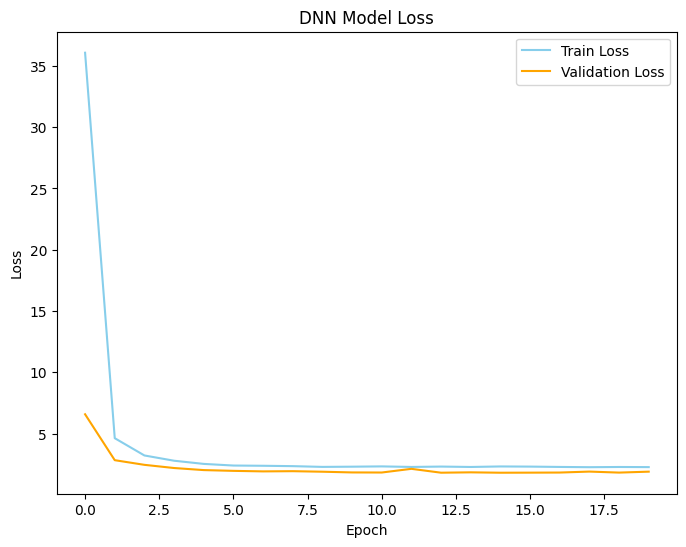

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Loss Plot
plt.plot(dnn_history.history['loss'], label='Train Loss', color='skyblue')
plt.plot(dnn_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('DNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [65]:
dnn_model.evaluate(X_train, y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1321 - mse: 2.1321


[2.1637086868286133, 2.1637086868286133]

In [64]:
dnn_model.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7416 - mse: 2.7416


[2.412980556488037, 2.412980079650879]